# Studienarbeit Data Exploration

## Laden einiger wichtiger Bibliotheken

In [1]:
import requests
import random
import warnings
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate
from typing import List, Tuple
from collections import Counter
from sklearn.metrics import confusion_matrix
from datasets import Dataset, DatasetDict
from collections import Counter
from matplotlib import cm
from transformers import (
    DistilBertTokenizerFast,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer
)


# 1.) Laden der Daten


In [2]:
#Statische Variablen
SETH_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/SETH-train.iob'
SETH_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/SETH-test.iob'

VARIOME_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome-train.iob'
VARIOME_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome-test.iob'

VARIOME120_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome120-train.iob'
VARIOME120_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome120-test.iob'

AMIA_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/amia-train.iob'
AMIA_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/amia-test.iob'

TMVAR_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/tmvar-train.iob'
TMVAR_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/tmvar-test.iob'

# Funktion, um die Daten von von Github herunterzuladen
def download_data(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Überprüfen, ob die Anfrage erfolgreich war
    with open(filename, 'w') as file:
        file.write(response.text)

# Herunterladen der Daten
download_data(SETH_TRAIN_URL, 'SETH-train.iob')
download_data(SETH_TEST_URL, 'SETH-test.iob')

download_data(VARIOME_TRAIN_URL, 'Variome-train.iob')
download_data(VARIOME_TEST_URL, 'Variome-test.iob')

download_data(VARIOME120_TRAIN_URL, 'Variome120-train.iob')
download_data(VARIOME120_TEST_URL, 'Variome120-test.iob')

download_data(AMIA_TRAIN_URL, 'amia-train.iob')
download_data(AMIA_TEST_URL, 'amia-test.iob')

download_data(TMVAR_TRAIN_URL, 'tmvar-train.iob')
download_data(TMVAR_TEST_URL, 'tmvar-test.iob')

# Funktion zum parsen der heruntergeladenen Daten
def read_data_with_sentences(filename):
    documents = []
    current_document = []
    current_sentence = []
    
    with open(filename, 'r') as file:
        next(file)  # Ignoriere die erste Zeile (Spaltenüberschriften)
        for line in file:
            line = line.strip()

            # Überspringe header oder leere Zeilen
            if not line or line == "Word,Tag" or line == ",O":
                continue
            
            # Prüfe, ob es eine Dokumenten-ID ist (beginnt mit "#" und hat kein "," bzw. Zeile != "#,O")
            if line.startswith("#") and "," not in line:  
                if current_document:  # Speichere aktuelles Dokument sofern vorhanden
                    documents.append(current_document)
                current_document = []  # Neues Dokument wird gestartet

            # Prüfe, ob es sich um das Satzende handelt.
            elif line == ",":  
                if current_sentence:  # Speichere aktuellen Satz sofern vorhanden
                    current_document.append(current_sentence)
                current_sentence = []  # Neuer Satz wird gestartet
            
            # Token und Label verarbeiten
            elif line:  
                try:
                    # Trenne Token und Label anhand des letzten Kommas (rsplit)
                    # Kann auch mehrere komma geben (z.B. ",,O")
                    token, label = line.rsplit(",", 1)
                    current_sentence.append((token, label))
                except ValueError:
                    print(f"Zeile konnte nicht verarbeitet werden: {line}")
        
        # Letzten Satz und Dokument speichern
        if current_sentence:  # Letzter Satz
            current_document.append(current_sentence)
        if current_document:  # Letztes Dokument
            documents.append(current_document)
    
    return documents

# 2.) Experiment vorbereiten


In [3]:
# Funktion zum Zählen von Sätzen und Entitäten
def count_sentences_and_entities(title, documents: List[List[List[Tuple[str, str]]]]) -> Tuple[int, int]:
    sentence_count = 0
    entity_count = 0
    
    for doc in documents:
        for sentence in doc:
            sentence_count += 1
            in_entity = False  # Status, ob wir in einer Entität sind
            
            """
            Hier hab ich 2 Möglichkeiten gesehen wie man Entitäten zählen kann
            1. Anzahl der Klassen != O
            2. B-* und I-* Tags zu einer Entität zusammenzählen

            Habe mich für den 2. Weg entscheiden, da sich dies realitätsnaher anfühlte
            """
            for _, label in sentence:
                if label.startswith("B-"):  # Beginn einer neuen Entität
                    entity_count += 1
                    in_entity = True  # Wir sind jetzt in einer Entität
                elif label.startswith("I-"):  # Innerhalb einer Entität
                    if not in_entity:  # Wenn kein "B-" Tag vorher war, ignorieren
                        continue
                else:
                    in_entity = False  # Nicht mehr in einer Entität
    
    print(f"{title}: {len(documents)} Dokumente, {sentence_count} Sätze, {entity_count} Entitäten")




In [4]:
datasets = [
    {"name": "SETH", "train": read_data_with_sentences("SETH-train.iob"), "test": read_data_with_sentences("SETH-test.iob")},
    {"name": "Variome", "train": read_data_with_sentences("Variome-train.iob"), "test": read_data_with_sentences("Variome-test.iob")},
    {"name": "Variome120", "train": read_data_with_sentences("Variome120-train.iob"), "test": read_data_with_sentences("Variome120-test.iob")},
    {"name": "Amia", "train": read_data_with_sentences("amia-train.iob"), "test": read_data_with_sentences("amia-test.iob")},
    {"name": "TmVar", "train": read_data_with_sentences("tmvar-train.iob"), "test": read_data_with_sentences("tmvar-test.iob")},
]

# Iteriere über die Datensätze und gebe Anzahl Sätze und Entities aus
for dataset in datasets:
    count_sentences_and_entities(
        title=f"{dataset['name']} Trainingsdaten", 
        documents=dataset["train"]
    )
    count_sentences_and_entities(
        title=f"{dataset['name']} Testdaten", 
        documents=dataset["test"]
    )

SETH Trainingsdaten: 504 Dokumente, 4007 Sätze, 2674 Entitäten
SETH Testdaten: 126 Dokumente, 951 Sätze, 543 Entitäten
Variome Trainingsdaten: 96 Dokumente, 1580 Sätze, 5125 Entitäten
Variome Testdaten: 24 Dokumente, 372 Sätze, 971 Entitäten
Variome120 Trainingsdaten: 96 Dokumente, 1580 Sätze, 87 Entitäten
Variome120 Testdaten: 24 Dokumente, 372 Sätze, 29 Entitäten
Amia Trainingsdaten: 100 Dokumente, 1082 Sätze, 1787 Entitäten
Amia Testdaten: 45 Dokumente, 500 Sätze, 752 Entitäten
TmVar Trainingsdaten: 334 Dokumente, 4067 Sätze, 982 Entitäten
TmVar Testdaten: 166 Dokumente, 1942 Sätze, 469 Entitäten


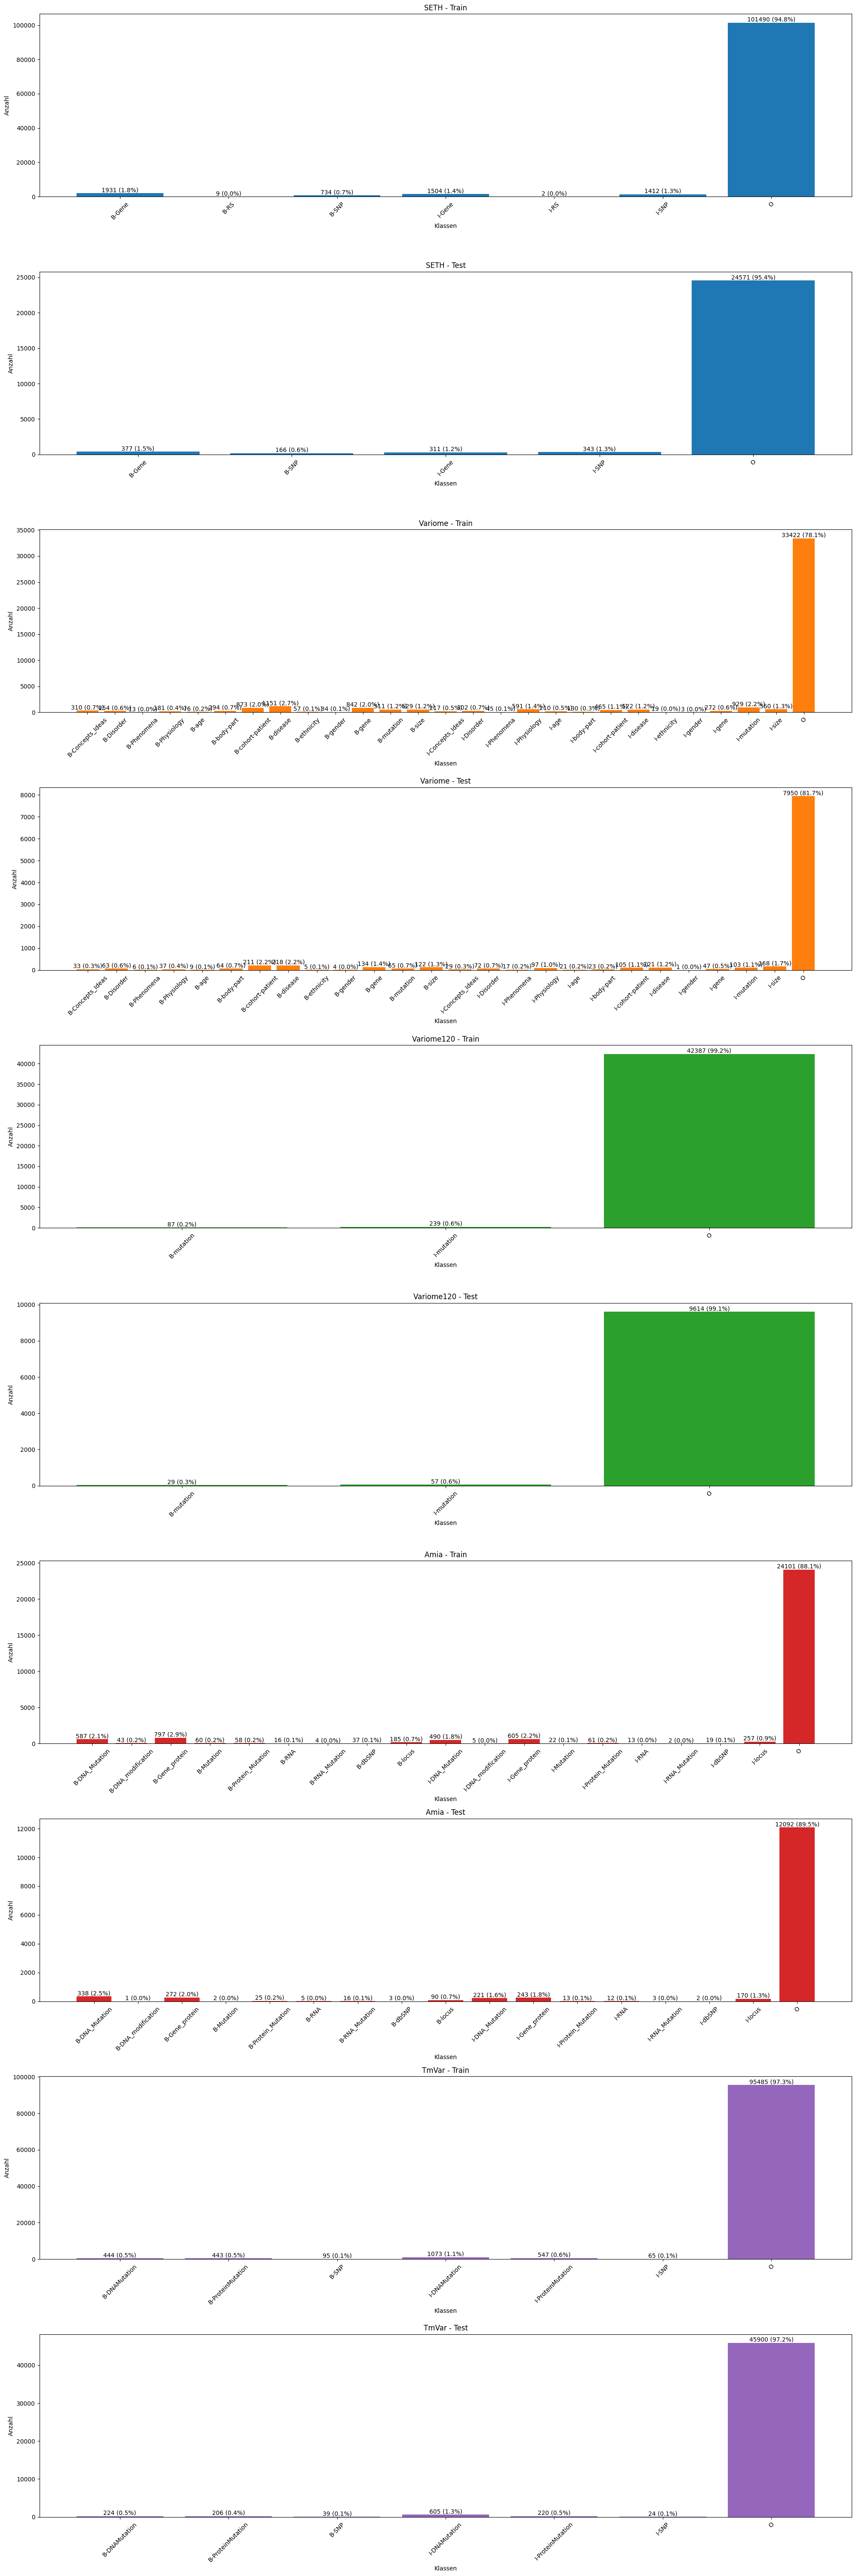

In [5]:
# Zähle und plotte die Klassenverteilung
def count_and_plot_classes(documents: List[List[List[Tuple[str, str]]]], ax, all_classes=None, color=None) -> None:
    labels = []
    for doc in documents:
        for sentence in doc:
            labels.extend(label for _, label in sentence)
    
    # Berechne die Klassenverteilung
    class_distribution = Counter(labels)
    
    # Falls `all_classes` nicht angegeben ist, ermitteln wir sie dynamisch
    if all_classes is None:
        all_classes = sorted(class_distribution.keys())  # Alphabetisch sortieren
    
    # Stelle sicher, dass alle gewünschten Klassen angezeigt werden (auch wenn sie nicht im aktuellen Datensatz vorkommen)
    for cls in all_classes:
        if cls not in class_distribution:
            class_distribution[cls] = 0  # Füge fehlende Klassen mit 0 hinzu
    
    # Sortiere die Klassen nach `all_classes`
    ordered_keys = all_classes
    ordered_values = [class_distribution[cls] for cls in ordered_keys]

    # Plot der Klassenverteilung
    bars = ax.bar(ordered_keys, ordered_values, color=color)
    
    # Absolute und prozentuale Werte hinzufügen
    total_count = sum(class_distribution.values())
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height} ({height / total_count * 100:.1f}%)', 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     ha='center', va='bottom')
    
    ax.set_xlabel('Klassen')
    ax.set_ylabel('Anzahl')




# Farben für die Datensätze aus einer Farbpalette
colors = cm.tab10(range(len(datasets)))  # Unterschiedliche Farben für die Datensätze

# Diagramm für alle Datensätze
fig, axs = plt.subplots(len(datasets) * 2, 1, figsize=(20, 6 * len(datasets) * 2))  # Eine Zeile pro Diagramm

for i, (dataset, color) in enumerate(zip(datasets, colors)):
    # Train split
    count_and_plot_classes(dataset["train"], axs[i * 2], color=color)
    axs[i * 2].set_title(f'{dataset["name"]} - Train')
    axs[i * 2].tick_params(axis='x', rotation=45)  # Drehe die x-Beschriftungen
    
    # Test split
    count_and_plot_classes(dataset["test"], axs[i * 2 + 1], color=color)
    axs[i * 2 + 1].set_title(f'{dataset["name"]} - Test')
    axs[i * 2 + 1].tick_params(axis='x', rotation=45)  # Drehe die x-Beschriftungen

plt.tight_layout()
plt.show()


In [6]:
# Funktion zur Aufteilung in Train/Dev
def split_documents(documents, train_ratio=0.8):
    random.shuffle(documents)  # Zufällige Reihenfolge der Dokumente
    split_index = int(len(documents) * train_ratio)
    train_split = documents[:split_index]
    dev_split = documents[split_index:]
    return train_split, dev_split

# Aktualisiere die Datasets-Liste mit Train/Dev-Splits
split_datasets = []

for data in datasets:
    print(f"Erzeuge Train/Dev-Split für {data['name']}...")
    
    # Train/Dev-Split durchführen
    train_split, dev_split = split_documents(data['train'], train_ratio=0.8)
    
    # Ergebnisse speichern
    split_datasets.append({
        "name": data["name"],
        "train": train_split,
        "dev": dev_split,
        "test": data["test"]
    })

Erzeuge Train/Dev-Split für SETH...
Erzeuge Train/Dev-Split für Variome...
Erzeuge Train/Dev-Split für Variome120...
Erzeuge Train/Dev-Split für Amia...
Erzeuge Train/Dev-Split für TmVar...


In [7]:
# Brauchen gemappte Labels, sonst zu wenig Überschneidung:
UNIFIED_LABELS = [
    "O",
    "B-Gene/Protein", "I-Gene/Protein",
    "B-SNP", "I-SNP",
    "B-Mutation", "I-Mutation",
    "B-DNA_Mutation", "I-DNA_Mutation",
    "B-RNA_Mutation", "I-RNA_Mutation",
    "B-Protein_Mutation", "I-Protein_Mutation",
    "B-Disease/Disorder", "I-Disease/Disorder",
    "B-Patient_Attribute", "I-Patient_Attribute",
    "B-Phenomena/Concepts", "I-Phenomena/Concepts",
    "B-Locus", "I-Locus",
    "B-Measurement", "I-Measurement",
    "B-Ethnicity", "I-Ethnicity",
]



LABEL_MAPPING = {
    "SETH": {
        "B-Gene": "B-Gene/Protein",
        "I-Gene": "I-Gene/Protein",
        "B-RS": "O",
        "I-RS": "O",
        "B-SNP": "B-SNP",
        "I-SNP": "I-SNP"
    },
    "Variome": {
        "B-Concepts_Ideas": "B-Phenomena/Concepts",
        "I-Concepts_Ideas": "I-Phenomena/Concepts",
        "B-Disorder": "B-Disease/Disorder",
        "I-Disorder": "I-Disease/Disorder",
        "B-Phenomena": "B-Phenomena/Concepts",
        "I-Phenomena": "I-Phenomena/Concepts",
        "B-Physiology": "B-Phenomena/Concepts",
        "I-Physiology": "I-Phenomena/Concepts",
        "B-age": "B-Patient_Attribute",
        "I-age": "I-Patient_Attribute",
        "B-gender": "B-Patient_Attribute",
        "I-gender": "I-Patient_Attribute",
        "B-body-part": "B-Patient_Attribute",
        "I-body-part": "I-Patient_Attribute",
        "B-cohort-patient": "B-Patient_Attribute",
        "I-cohort-patient": "I-Patient_Attribute",
        "B-disease": "B-Disease/Disorder",
        "I-disease": "I-Disease/Disorder",
        "B-ethnicity": "B-Ethnicity",
        "I-ethnicity": "I-Ethnicity",
        "B-gene": "B-Gene/Protein",
        "I-gene": "I-Gene/Protein",
        "B-mutation": "B-Mutation",
        "I-mutation": "I-Mutation",
        "B-size": "B-Measurement",
        "I-size": "I-Measurement"
    },
    "Variome120": {
        "B-mutation": "B-Mutation",
        "I-mutation": "I-Mutation"
    },
    "Amia": {
        "B-DNA_Mutation": "B-DNA_Mutation",
        "I-DNA_Mutation": "I-DNA_Mutation",
        "B-DNA_modification": "B-DNA_Mutation",
        "I-DNA_modification": "I-DNA_Mutation",
        "B-Gene_protein": "B-Gene/Protein",
        "I-Gene_protein": "I-Gene/Protein",
        "B-Mutation": "B-Mutation",
        "I-Mutation": "I-Mutation",
        "B-Protein_mutation": "B-Protein_Mutation",
        "I-Protein_mutation": "I-Protein_Mutation",
        "B-RNA": "B-RNA_Mutation",
        "I-RNA": "I-RNA_Mutation",
        "B-RNA_Mutation": "B-RNA_Mutation",
        "I-RNA_Mutation": "I-RNA_Mutation",
        "B-dbSNP": "B-SNP",
        "I-dbSNP": "I-SNP",
        "B-Iocus": "B-Locus",
        "I-Iocus": "I-Locus"
    },
    "TmVar": {
        "B-DNAMutation": "B-DNA_Mutation",
        "I-DNAMutation": "I-DNA_Mutation",
        "B-ProteinMutation": "B-Protein_Mutation",
        "I-ProteinMutation": "I-Protein_Mutation",
        "B-SNP": "B-SNP",
        "I-SNP": "I-SNP"
    }
}




LABEL_TO_ID = {label: idx for idx, label in enumerate(UNIFIED_LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

In [8]:
#Mapping-Funktion
def map_labels(corpus_name, raw_label):
    mapping = LABEL_MAPPING.get(corpus_name, {})
    if raw_label in mapping:
        return mapping[raw_label]
    else:
        warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
        return "O"

# 3.) Trainieren Sie einen Transformer zur Eigennamenerkennung

In [9]:
#Daten für Training vorbereiten und in die richtige Form bringen
def prepare_data(documents, corpus_name):
    sentences = []
    labels = []
    for doc in documents:
        for sentence in doc:
            sentences.append([token for token, _ in sentence])
            labels.append([
                LABEL_TO_ID[map_labels(corpus_name, label)] for _, label in sentence
            ])
   
    return Dataset.from_dict({"tokens": sentences, "ner_tags": labels})

In [10]:
# Wende prepare_data auf die train, dev und test-Splits an
processed_datasets = []

for data in split_datasets:
    print(f"Verarbeite {data['name']}...")

    # Trainingsdaten vorbereiten
    train_dataset = prepare_data(data["train"], data["name"])

    # Dev-Daten vorbereiten
    dev_dataset = prepare_data(data["dev"], data["name"])

    # Testdaten vorbereiten
    test_dataset = prepare_data(data["test"], data["name"])

    # Speichern der verarbeiteten Datasets
    processed_datasets.append({
        "name": data["name"],
        "train": train_dataset,
        "dev": dev_dataset,
        "test": test_dataset
    })

Verarbeite SETH...


C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'O' aus Datensatz 'SETH' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'B-RS' aus Datensatz 'SETH' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'I-RS' aus Datensatz 'SETH' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")


Verarbeite Variome...
Verarbeite Variome120...
Verarbeite Amia...


C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'O' aus Datensatz 'Variome' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'B-Concepts_Ideas' aus Datensatz 'Variome' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'B-size' aus Datensatz 'Variome' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'I-size' aus Datensatz 'Variome' konnte nicht gemappt werden. Fall

Verarbeite TmVar...


C:\Users\denis\AppData\Local\Temp\ipykernel_18448\3155691684.py:7: UserWarning: Label 'O' aus Datensatz 'TmVar' konnte nicht gemappt werden. Fallback zu 'O'.
  warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")


In [10]:
# Tokenizer initialisieren
pretrained_model = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model, clean_up_tokenization_spaces=True)


"""
Funktion ordnet NER-Labels den tokenisierten Eigaben basierend auf Wort-IDs zu.
Notwendig, da Tokenizer Wörter in mehrere Tokenaufteilen.

Tokens die beim Training nicht berücksichtigt werden soll, wird der Wert -100 zugewiesen
"""
def align_labels(original_labels, word_ids):
    aligned_labels = []
    previous_word_id = None

    for word_idx in word_ids:
        if word_idx != previous_word_id:
            # Beginn eines neuen Wortes oder Special Token
            if word_idx is None:  # Special Token
                aligned_labels.append(-100)
            else:  # Beginn eines neuen Wortes, altes wird gespeichert
                aligned_labels.append(original_labels[word_idx])
            previous_word_id = word_idx
        else:
            if word_idx is None: #Es handelt sich um ein Special token
                aligned_labels.append(-100)
            else:
                # Das Token gehört zum selben Wort wie das vorherige Token
                label = original_labels[word_idx]
                # Wenn das Label B-* ist, ändere es zu I-* (B-* sind ungerade Labels)
                if label % 2 == 1:
                    label += 1
                aligned_labels.append(label)
    return aligned_labels


#Funktion tokenisiert die Eingabetexte und ordnet entsprechende Labels zu
def tokenize_and_allign(inputs):
    tokenized_inputs = tokenizer(
        inputs["tokens"], truncation=True, is_split_into_words=True
    )

    original_labels = inputs["ner_tags"] # Originallabels aus den Eingabedaten
    aligned_labels = []
    for i, labels_per_sentence in enumerate(original_labels):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels.append(align_labels(labels_per_sentence, word_ids))

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs


In [11]:
# Tokenisierte Datensätze erstellen
tokenized_datasets = {}

for data in processed_datasets:
    print(f"Tokenisiere {data['name']}...")

    # Tokenisiere und aligniere die train-, dev- und test-Splits
    train_tokenized = data["train"].map(
        tokenize_and_align,
        batched=True,
        remove_columns=data["train"].column_names
    )
    dev_tokenized = data["dev"].map(
        tokenize_and_align,
        batched=True,
        remove_columns=data["dev"].column_names
    )
    test_tokenized = data["test"].map(
        tokenize_and_align,
        batched=True,
        remove_columns=data["test"].column_names
    )

    # Speichere die tokenisierten Datensätze in einem Dictionary
    tokenized_datasets[data["name"]] = {
        "train": train_tokenized,
        "dev": dev_tokenized,
        "test": test_tokenized
    }

#Data Collator stellt sicher, dass Daten in richtigem Format für Training vorliegen
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


Map:   0%|          | 0/3208 [00:00<?, ? examples/s]

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

In [12]:
#Nur zu Debugging-Zwecken
"""
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])

for i in range(2):
    print(f"Sample {i + 1}:")
    #Original Tokens
    print(raw_datasets["train"][i]["tokens"])
    #"Labels nach Tokenisierung
    print(tokenized_datasets["train"][i]["labels"])
    #Labels nach Data Collator
    print(batch["labels"][i].tolist())
"""

Sample 1:
['A', 'congenital', 'muscular', 'dystrophy', 'with', 'mitochondrial', 'structural', 'abnormalities', 'caused', 'by', 'defective', 'de', 'novo', 'phosphatidylcholine', 'biosynthesis', '.']
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100]
Sample 2:
['Congenital', 'muscular', 'dystrophy', 'is', 'a', 'heterogeneous', 'group', 'of', 'inherited', 'muscle', 'diseases', 'characterized', 'clinically', 'by', 'muscle', 'weakness', 'and', 'hypotonia', 'in', 'early', 'infancy', '.']
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [13]:
#Prepare Metrics
metric = evaluate.load("seqeval")

def calculate_metrics(predictions_and_labels):
    logits, labels = predictions_and_labels
    predicted_labels  = np.argmax(logits, axis=-1)

    
    true_labels = []
    true_predictions = []

    # Entferne special tokens und konvertierte von IDs zu labels
    for sentence_labels, sentence_predictions in zip(labels, predicted_labels):
        true_labels.append([UNIFIED_LABELS[label] for label in sentence_labels if label != -100])
        true_predictions.append([UNIFIED_LABELS[prediction] for prediction, label 
                                 in zip(sentence_predictions, sentence_labels) if label != -100])

    overall_metrics = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)

    # Extrahiere die allgemeinen Metriken
    overall_result = {
        "accuracy": overall_metrics["overall_accuracy"],
        "f1": overall_metrics["overall_f1"],
        "precision": overall_metrics["overall_precision"],
        "recall": overall_metrics["overall_recall"],
    }

    return overall_result

## 3.1) DistillBert oder PubMedBERT für mindestens 3 Epochen trainieren

In [14]:
# Modell für die Token-Klassifikation laden
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model,
    id2label=ID_TO_LABEL,
    label2id=LABEL_TO_ID,
)

# Trainingsargumente definieren
args = TrainingArguments(
    save_strategy="epoch",  # Speichern des Modells nach jeder Epoche
    eval_strategy="epoch",   # Evaluation nach jeder Epoche
    logging_strategy="epoch",  # Logging nach jeder Epoche
    learning_rate=2e-5,      # Lernrate, müsste man austesten was am besten ist
    num_train_epochs=3,      # Anzahl der Trainingsepochen
    weight_decay=0.01,       # Gewichtungsverfall zur Vermeidung von Overfitting
    load_best_model_at_end=True,  # Bestes Modell am Ende laden
    output_dir="./results",  # Ausgabeordner für die Ergebnisse
    logging_dir='./logs',     # Ausgabeordner für Logs
)

# Trainer-Instanz erstellen
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["SETH"]["train"],
    eval_dataset=tokenized_datasets["SETH"]["dev"],
    data_collator=data_collator,
    compute_metrics=calculate_metrics,
    tokenizer=tokenizer,
)

# Training des Modells starten
trainer.train()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2005 [00:00<?, ?it/s]

{'loss': 0.1811, 'grad_norm': 1.314166784286499, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.06862963736057281, 'eval_accuracy': 0.9763986661726566, 'eval_f1': 0.6424361493123772, 'eval_precision': 0.5828877005347594, 'eval_recall': 0.7155361050328227, 'eval_runtime': 52.8217, 'eval_samples_per_second': 15.126, 'eval_steps_per_second': 1.893, 'epoch': 1.0}
{'loss': 0.0623, 'grad_norm': 1.082062005996704, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.07157108932733536, 'eval_accuracy': 0.9766209707299, 'eval_f1': 0.6949654491609082, 'eval_precision': 0.6330935251798561, 'eval_recall': 0.7702407002188184, 'eval_runtime': 49.4385, 'eval_samples_per_second': 16.161, 'eval_steps_per_second': 2.023, 'epoch': 2.0}
{'loss': 0.0399, 'grad_norm': 0.694304347038269, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.07400533556938171, 'eval_accuracy': 0.9792515746572805, 'eval_f1': 0.739406779661017, 'eval_precision': 0.7166324435318275, 'eval_recall': 0.7636761487964989, 'eval_runtime': 53.3004, 'eval_samples_per_second': 14.991, 'eval_steps_per_second': 1.876, 'epoch': 3.0}
{'loss': 0.0232, 'grad_norm': 2.412059783935547, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.0891055017709732, 'eval_accuracy': 0.9777695442756577, 'eval_f1': 0.7401069518716576, 'eval_precision': 0.7238493723849372, 'eval_recall': 0.7571115973741794, 'eval_runtime': 64.4044, 'eval_samples_per_second': 12.406, 'eval_steps_per_second': 1.553, 'epoch': 4.0}
{'loss': 0.0145, 'grad_norm': 0.022317443042993546, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.09468474239110947, 'eval_accuracy': 0.9779547980733605, 'eval_f1': 0.7470899470899471, 'eval_precision': 0.7233606557377049, 'eval_recall': 0.7724288840262582, 'eval_runtime': 67.1648, 'eval_samples_per_second': 11.896, 'eval_steps_per_second': 1.489, 'epoch': 5.0}
{'train_runtime': 5001.0151, 'train_samples_per_second': 3.207, 'train_steps_per_second': 0.401, 'train_loss': 0.06417788721974056, 'epoch': 5.0}


TrainOutput(global_step=2005, training_loss=0.06417788721974056, metrics={'train_runtime': 5001.0151, 'train_samples_per_second': 3.207, 'train_steps_per_second': 0.401, 'total_flos': 277775227886640.0, 'train_loss': 0.06417788721974056, 'epoch': 5.0})

## 3.2) Plotten Sie für das Modell den Train/Dev-Loss und die Accuracy über die Epochen

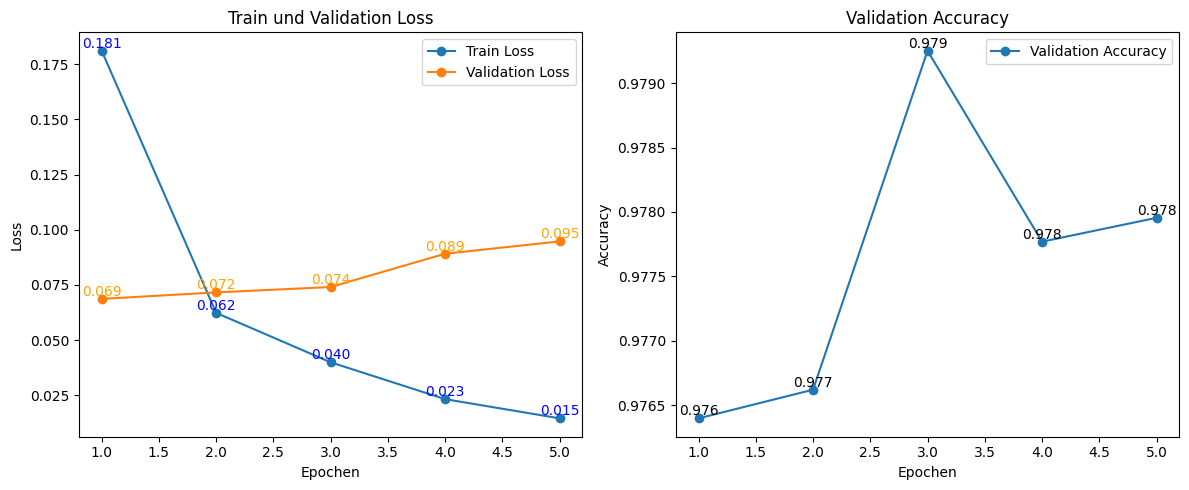

In [15]:
log_history = trainer.state.log_history
train_losses = []
eval_losses = []
eval_accuracies = []
steps = []

# Extrahiere train und evaluation loss/accuracy für jeden Schritt
train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracies = [log.get('eval_accuracy') for log in log_history if 'eval_accuracy' in log]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot für train und validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, eval_losses, label="Validation Loss", marker="o")

# Zeige die genauen Loss-Werte für jeden Punkt (Train + Validation) an
for i, (train_loss, eval_loss) in enumerate(zip(train_losses, eval_losses)):
    plt.text(i + 1, train_loss, f'{train_loss:.3f}', ha='center', va='bottom', color='blue')  # Blau für Train Loss
    plt.text(i + 1, eval_loss, f'{eval_loss:.3f}', ha='center', va='bottom', color='orange')  # Orange für Validation Loss

plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.title("Train und Validation Loss")
plt.legend()

# Plot für validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracies, label="Validation Accuracy", marker="o")

# Zeige die genauen Accuracy-Werte für jeden Punkt an
for i, accuracy in enumerate(eval_accuracies):
    plt.text(i + 1, accuracy, f'{accuracy:.3f}', ha='center', va='bottom')

plt.xlabel("Epochen")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 3.3) Beobachten Sie Anzeichen von Overfitting? Würden Sie das Modell für weitere Epochen trainieren wollen? Begründen Sie Ihre Antwort


# 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten

## 4.1) Schätzen Sie die Accuracy Ihrer Methode für jede Klasse separat, sowie für alle Klassen

In [16]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])

# Konvertiere die Logits in Vorhersagen (Indices der höchsten Werte)
predictions = np.argmax(predictions, axis=-1)

# Bereite die Labels und Vorhersagen zur Auswertung vor
true_labels = [[ALL_CLASSES[l] for l in label if l != -100] for label in labels]
pred_labels = [[ALL_CLASSES[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]

# Initialisiere eine Liste für die Klassengenauigkeit
class_accuracy_results = []

# Berechnung der Klasse-spezifischen Accuracy
for cls in ALL_CLASSES:
    true_positive = sum(1 for true, pred in zip(true_labels, pred_labels) if cls in true and cls in pred)
    total_class = sum(1 for true in true_labels if cls in true)

    if total_class > 0:
        class_accuracy = true_positive / total_class
    else:
        class_accuracy = 0.0  # Keine Instanzen für diese Klasse

    # Füge das Ergebnis der Liste hinzu
    class_accuracy_results.append({"Klasse": cls, "Accuracy": class_accuracy})

# Konvertiere die Liste in ein DataFrame
accuracy_df = pd.DataFrame(class_accuracy_results)

# Zeige die Tabelle an
print(tabulate(class_accuracy_results, headers="keys", tablefmt="grid", floatfmt=".4f"))

  0%|          | 0/119 [00:00<?, ?it/s]

+----------+------------+
| Klasse   |   Accuracy |
+==========+============+
| O        |     1.0000 |
+----------+------------+
| B-RS     |     0.0000 |
+----------+------------+
| I-RS     |     0.0000 |
+----------+------------+
| B-SNP    |     0.8551 |
+----------+------------+
| I-SNP    |     0.8857 |
+----------+------------+
| B-Gene   |     0.8939 |
+----------+------------+
| I-Gene   |     0.9278 |
+----------+------------+


## 4.2 Nutzen Sie die Bibliothek seqeval zur Evaluation

In [17]:
seqeval_metrics = metric.compute(predictions=pred_labels, references=true_labels)

# Gesamtmetriken ausgeben
print("Gesamtmetriken:")
print(f"Precision: {seqeval_metrics['overall_precision']:.4f}")
print(f"Recall: {seqeval_metrics['overall_recall']:.4f}")
print(f"F1-Score: {seqeval_metrics['overall_f1']:.4f}")
print(f"Accuracy: {seqeval_metrics['overall_accuracy']:.4f}")

Gesamtmetriken:
Precision: 0.5074
Recall: 0.6912
F1-Score: 0.5852
Accuracy: 0.9704


## 4.3 Erzeugen Sie eine Confusion Matrix

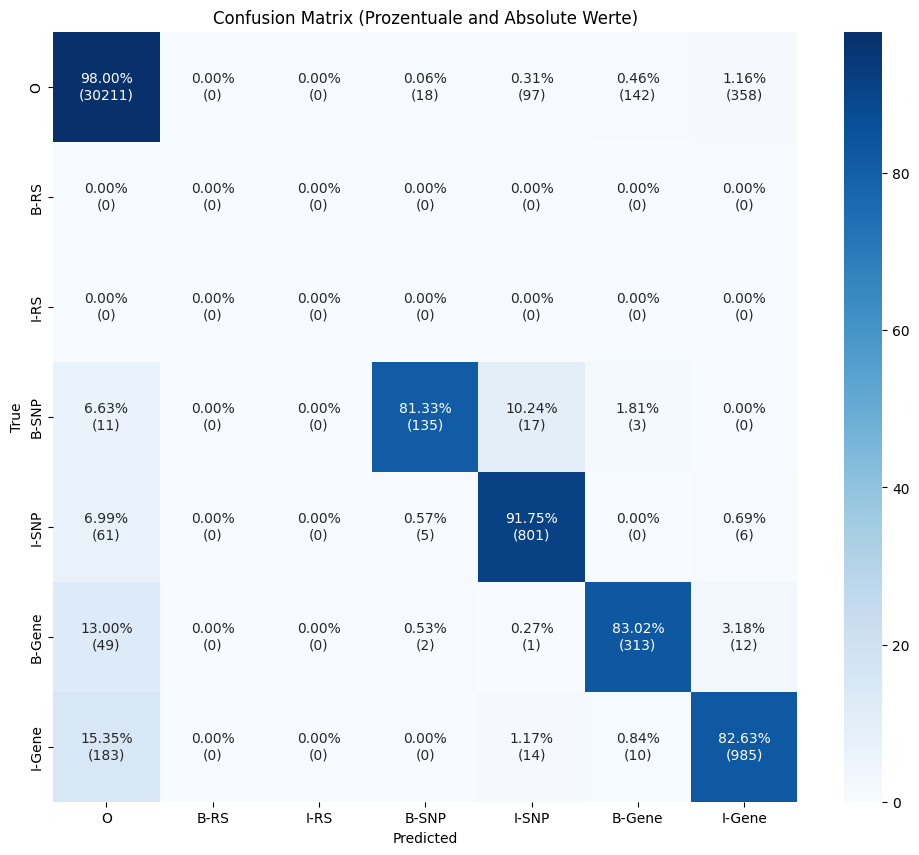

In [18]:
# Flache die Listen von Labels und Vorhersagen (nur gültige Tokens)
true_labels_flat = [label for sublist in true_labels for label in sublist]
pred_labels_flat = [pred for sublist in pred_labels for pred in sublist]

# Berechne die Confusion-Matrix (absolute Werte)
cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=ALL_CLASSES)

# Berechnung der prozentualen Werte mit 0-Check
cm_sum = cm.sum(axis=1)[:, np.newaxis]  # Summiere die Zeilen
cm_percentage = np.zeros_like(cm, dtype=float)  # Initialisiere die prozentuale Matrix

# Fülle die Matrix nur, wenn die Summe größer als 0 ist
for i in range(len(cm)):
    if cm_sum[i, 0] > 0:
        cm_percentage[i] = cm[i] / cm_sum[i, 0] * 100  # Berechne den Prozentsatz

# Format für die Annotation: 'Prozentsatz (absolute Zahl)'
# Für uns ist vor Allem die Prozentuale Anzah linteressant, da die O-Klasse sonst alle überschattet
annotations = np.array([["{:.2f}%\n({})".format(cm_percentage[i, j], cm[i, j])
                         for j in range(len(ALL_CLASSES))] for i in range(len(ALL_CLASSES))])

# Plot Confusion-Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percentage, annot=annotations, fmt='', xticklabels=ALL_CLASSES, yticklabels=ALL_CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Prozentuale and Absolute Werte)')
plt.show()

## 4.4 Interpretation der Confusion-Matrix. Welche Klasse ist am schwersten zu klassifizieren und mit welchen Klassen wird sie oft „verwechselt“

Basierend auf diesen Werten ist **B-SNP** mit **81.33%** die am schwersten zu klassifizierende Klasse
- **81.33%** (135 Fälle) werden **korrekt** als **B-SNP** klassifiziert
- **10.24%** (17 Fälle) werden fälschlicherweise als **I-SNP** klassifiziert
- **6.63%** (11 Fälle) werden fälschlicherweise als **O** klassifiziert
- **1.81%** (3 Fälle) werden fälschlicherweise als **B-Gene** klassifiziert

-> **B-SNP** wird also hauptsächlich mit **I-SNP** (**10.24%**) verwechselt

# 5.) Geben Sie für das erste Dokument im Test-Set die vorhergesagten Labels für jeden IOB-Token aus

In [27]:
# Berechne die Vorhersagen für den Test-Datensatz
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])

# Konvertiere die Logits in Vorhersagen
predictions = np.argmax(predictions, axis=-1)

# Funktion zum printen der tokens mit predicted und true label
def display_document_prediction_comparison(document_id):

    # Erhalte die Anzahl der Sätze im gewählten Dokument
    count_sentences_doc = len(test_documents[document_id])

    # Schaue nach, wo das Dokument anfängt
    start_index = sum(len(test_documents[i]) for i in range(document_id))  # Summe der Längen der vorherigen Dokumente

    # Frage das Dokument in der Spanne ab
    document = tokenized_datasets["test"][start_index:start_index + count_sentences_doc]
    doc_predictions = predictions[start_index:start_index + count_sentences_doc]
    doc_labels = labels[start_index:start_index + count_sentences_doc]

    # Dekodiere die input_ids zurück zu Tokens (Wörtern)
    input_ids = document['input_ids']
    tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]

    # Listen für die Tokens, wahren Labels, vorhergesagten Labels und Satz-IDs
    filtered_tokens = []
    true_labels_doc = []
    pred_labels_doc = []
    sentence_ids = []

    # Durchlaufe alle Sätze und deren Tokens
    for i in range(count_sentences_doc):
        # Hole den aktuellen Satz und die zugehörigen Vorhersagen und Labels
        sentence_tokens = tokens[i]  # Hole die Tokens des Satzes
        preds = doc_predictions[i]  # Vorhersagen für den Satz
        true_labels = doc_labels[i]  # Wahre Labels für den Satz

        # Durchlaufe die Tokens und hole die zugehörigen Vorhersagen und Labels
        for token, pred, label in zip(sentence_tokens, preds, true_labels):
            if label != -100:  # Nur Tokens und Labels hinzufügen, wenn das Label nicht -100 ist
                filtered_tokens.append(token)
                true_labels_doc.append(ALL_CLASSES[label])
                pred_labels_doc.append(ALL_CLASSES[pred])
                sentence_ids.append(i)  # Füge die Satz-ID hinzu

    # Erstelle einen DataFrame für die Darstellung
    results_df = pd.DataFrame({
        'Sentence ID': sentence_ids,
        'Token': filtered_tokens,
        'Predicted Label': pred_labels_doc,
        'True Label': true_labels_doc
    })

    # Ergebnis ausgeben
    print(tabulate(results_df, headers='keys', tablefmt='grid'))


display_document_prediction_comparison(0)

  0%|          | 0/119 [00:00<?, ?it/s]

+-----+---------------+----------------+-------------------+--------------+
|     |   Sentence ID | Token          | Predicted Label   | True Label   |
+=====+===============+================+===================+==============+
|   0 |             0 | an             | O                 | O            |
+-----+---------------+----------------+-------------------+--------------+
|   1 |             0 | exponential    | O                 | O            |
+-----+---------------+----------------+-------------------+--------------+
|   2 |             0 | combination    | O                 | O            |
+-----+---------------+----------------+-------------------+--------------+
|   3 |             0 | procedure      | O                 | O            |
+-----+---------------+----------------+-------------------+--------------+
|   4 |             0 | for            | O                 | O            |
+-----+---------------+----------------+-------------------+--------------+
|   5 |     

In [28]:
""""
Da das erste Dokument nur aus 0-Labels besteht, printen wir das 3. Dokument
Das 3. Dokument ist das erste mit nicht O-Klassen, sodass man sehen kann, ob die prediction Sinn macht
"""
display_document_prediction_comparison(2)

+----+---------------+----------------+-------------------+--------------+
|    |   Sentence ID | Token          | Predicted Label   | True Label   |
+====+===============+================+===================+==============+
|  0 |             0 | identification | O                 | O            |
+----+---------------+----------------+-------------------+--------------+
|  1 |             0 | of             | O                 | O            |
+----+---------------+----------------+-------------------+--------------+
|  2 |             0 | four           | O                 | O            |
+----+---------------+----------------+-------------------+--------------+
|  3 |             0 | novel          | O                 | O            |
+----+---------------+----------------+-------------------+--------------+
|  4 |             0 | mutations      | O                 | O            |
+----+---------------+----------------+-------------------+--------------+
|  5 |             0 | in